# To-do

- change attribute types to decrease size

# <center> Credit card fraud </center>

The goal of this project is to apply ML techniques to predict fraud in credit card transactions. A comparison is also made between a traditional solution and one that takes into account concept drift in the data.

**Dataset information**: 

The dataset contains transactions made by credit cards in September 2013 by European cardholders.

Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'.
- 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset
- 'Amount' is the transaction Amount
- Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise

# Requirements

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
%matplotlib inline

from xgboost import XGBClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, RocCurveDisplay, auc

from imblearn.under_sampling import TomekLinks, RandomUnderSampler
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

# Get Data

In [2]:
# load data
df = pd.read_csv('./creditcard_data.csv')

# transform column names
df.columns = df.columns.str.lower()

df

,time,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v21,v22,v23,v24,v25,v26,v27,v28,amount,class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   time    284807 non-null  float64
 1   v1      284807 non-null  float64
 2   v2      284807 non-null  float64
 3   v3      284807 non-null  float64
 4   v4      284807 non-null  float64
 5   v5      284807 non-null  float64
 6   v6      284807 non-null  float64
 7   v7      284807 non-null  float64
 8   v8      284807 non-null  float64
 9   v9      284807 non-null  float64
 10  v10     284807 non-null  float64
 11  v11     284807 non-null  float64
 12  v12     284807 non-null  float64
 13  v13     284807 non-null  float64
 14  v14     284807 non-null  float64
 15  v15     284807 non-null  float64
 16  v16     284807 non-null  float64
 17  v17     284807 non-null  float64
 18  v18     284807 non-null  float64
 19  v19     284807 non-null  float64
 20  v20     284807 non-null  float64
 21  v21     28

There is no missing data.

In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
time,284807.0,9.481386e+04,47488.145955,0.000000,54201.500000,84692.000000,139320.500000,172792.000000
v1,284807.0,1.168375e-15,1.958696,-56.407510,-0.920373,0.018109,1.315642,2.454930
v2,284807.0,3.416908e-16,1.651309,-72.715728,-0.598550,0.065486,0.803724,22.057729
v3,284807.0,-1.379537e-15,1.516255,-48.325589,-0.890365,0.179846,1.027196,9.382558
v4,284807.0,2.074095e-15,1.415869,-5.683171,-0.848640,-0.019847,0.743341,16.875344
v5,284807.0,9.604066e-16,1.380247,-113.743307,-0.691597,-0.054336,0.611926,34.801666
v6,284807.0,1.487313e-15,1.332271,-26.160506,-0.768296,-0.274187,0.398565,73.301626
v7,284807.0,-5.556467e-16,1.237094,-43.557242,-0.554076,0.040103,0.570436,120.589494
v8,284807.0,1.213481e-16,1.194353,-73.216718,-0.208630,0.022358,0.327346,20.007208
v9,284807.0,-2.406331e-15,1.098632,-13.434066,-0.643098,-0.051429,0.597139,15.594995


Unfortunately, with no more information on the columns, further feature engineering isn't possible, including transformations from business rules and knowledge. Some example of features that can be included:

**from signifyd**
- IP
- address
- click behavior (amount of clicks, click speed)
- other behavioral data
- purchase history

**new variables**
- period of purchase (morning, afternoon, night)
- day of purchase (weekday, weekend)
- pages/products visited in website (avg amount)
- average purchase amount

# Exploratory Analysis

## Univariate

Total time elapsed: 1 day, 23:59:52


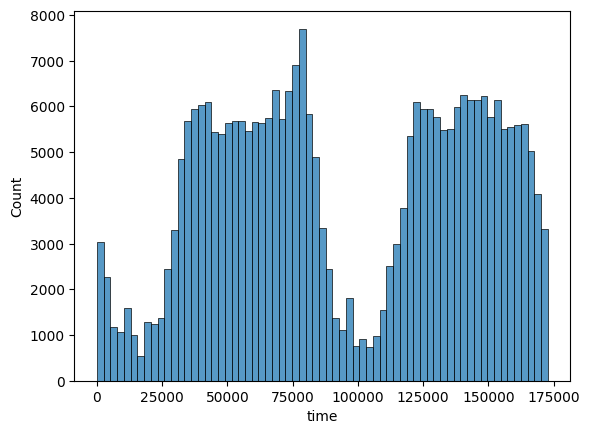

In [5]:
print('Total time elapsed:', dt.timedelta(seconds=df.loc[df.index[-1], 'time']))

sns.histplot(df['time']);

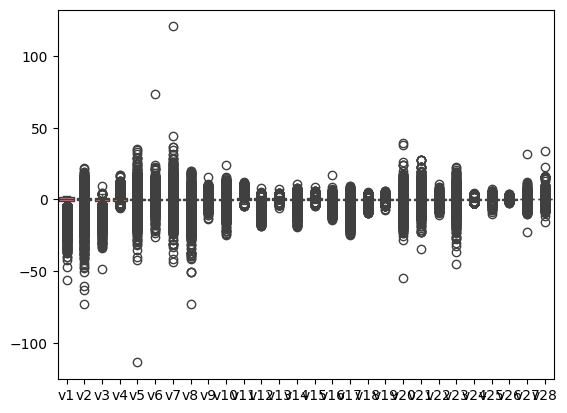

In [6]:
# numeric variables
sns.boxplot(df.iloc[:, 1:-2]);

There is a very heavy presence of outliers in all of the numeric variables, a not so strict method of outlier removal can be applied as to not remove too many instances.

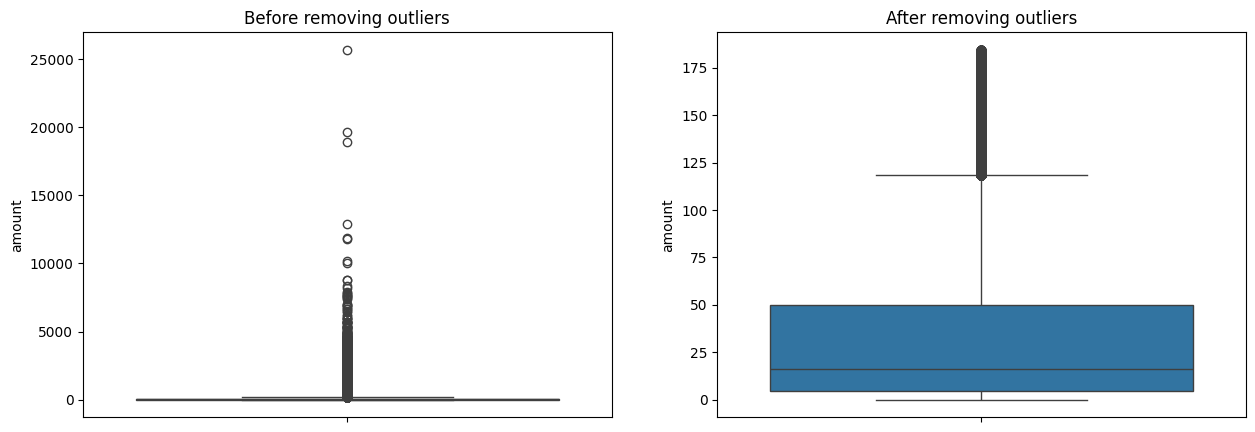

In [7]:
# amount analysis
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.boxplot(df['amount'], ax=ax[0])
ax[0].set_title('Before removing outliers')

# Remove outliers
Q1 = df['amount'].quantile(0.25)
Q3 = df['amount'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - (1.5 * IQR)
upper_bound = Q3 + (1.5 * IQR)
df_no_outliers = df[(df['amount'] >= lower_bound) & (df['amount'] <= upper_bound)]

sns.boxplot(data=df_no_outliers['amount'], ax=ax[1])
ax[1].set_title('After removing outliers')
plt.show()


Most common transactions are of value lower than 25 euros.

In [8]:
# Target variable, extremely imbalanced
print('Legit:', df[df['class'] == 0.].shape[0], f'({round(df[df["class"] == 0.].shape[0] / df.shape[0] * 100, 4)} %)')
print('Fraud:', df[df['class'] == 1.].shape[0], f'({round(df[df["class"] == 1.].shape[0] / df.shape[0] * 100, 4)} %)')
print()

print('Avg normal amount:', round(df[df['class'] == 0]['amount'].mean(), 2), 'Euros')
print('Avg fraud amount:', round(df[df['class'] == 1]['amount'].mean(), 2), 'Euros')
print('Highest fraud amount:', round(df[df['class'] == 1]['amount'].max(), 2), 'Euros')
print()

print("Cost of fraud (assuming 207 Euros for each 100 Euros or 2.07x, from Signifyd's State of Fraud Report)")
print('Amount cost of fraud:', df[df['class'] == 1]['amount'].sum())
print('Total cost for 2 days of transactions:', df[df['class'] == 1]['amount'].sum() * 2.07)
print(f"For a whole year: {(df[df['class'] == 1]['amount'].sum() * 2.07 * 365 / 2):,.2f} Euros")
print()

print ('Source: https://resources.signifyd.com/c/2023-state-of-fraud-report?x=1D3vGe')

Legit: 284315 (99.8273 %)
Fraud: 492 (0.1727 %)

Avg normal amount: 88.29 Euros
Avg fraud amount: 122.21 Euros
Highest fraud amount: 2125.87 Euros

Cost of fraud (assuming 207 Euros for each 100 Euros or 2.07x, from Signifyd's State of Fraud Report)
Amount cost of fraud: 60127.97
Total cost for 2 days of transactions: 124464.8979
For a whole year: 22,714,843.87 Euros

Source: https://resources.signifyd.com/c/2023-state-of-fraud-report?x=1D3vGe


## Bivariate

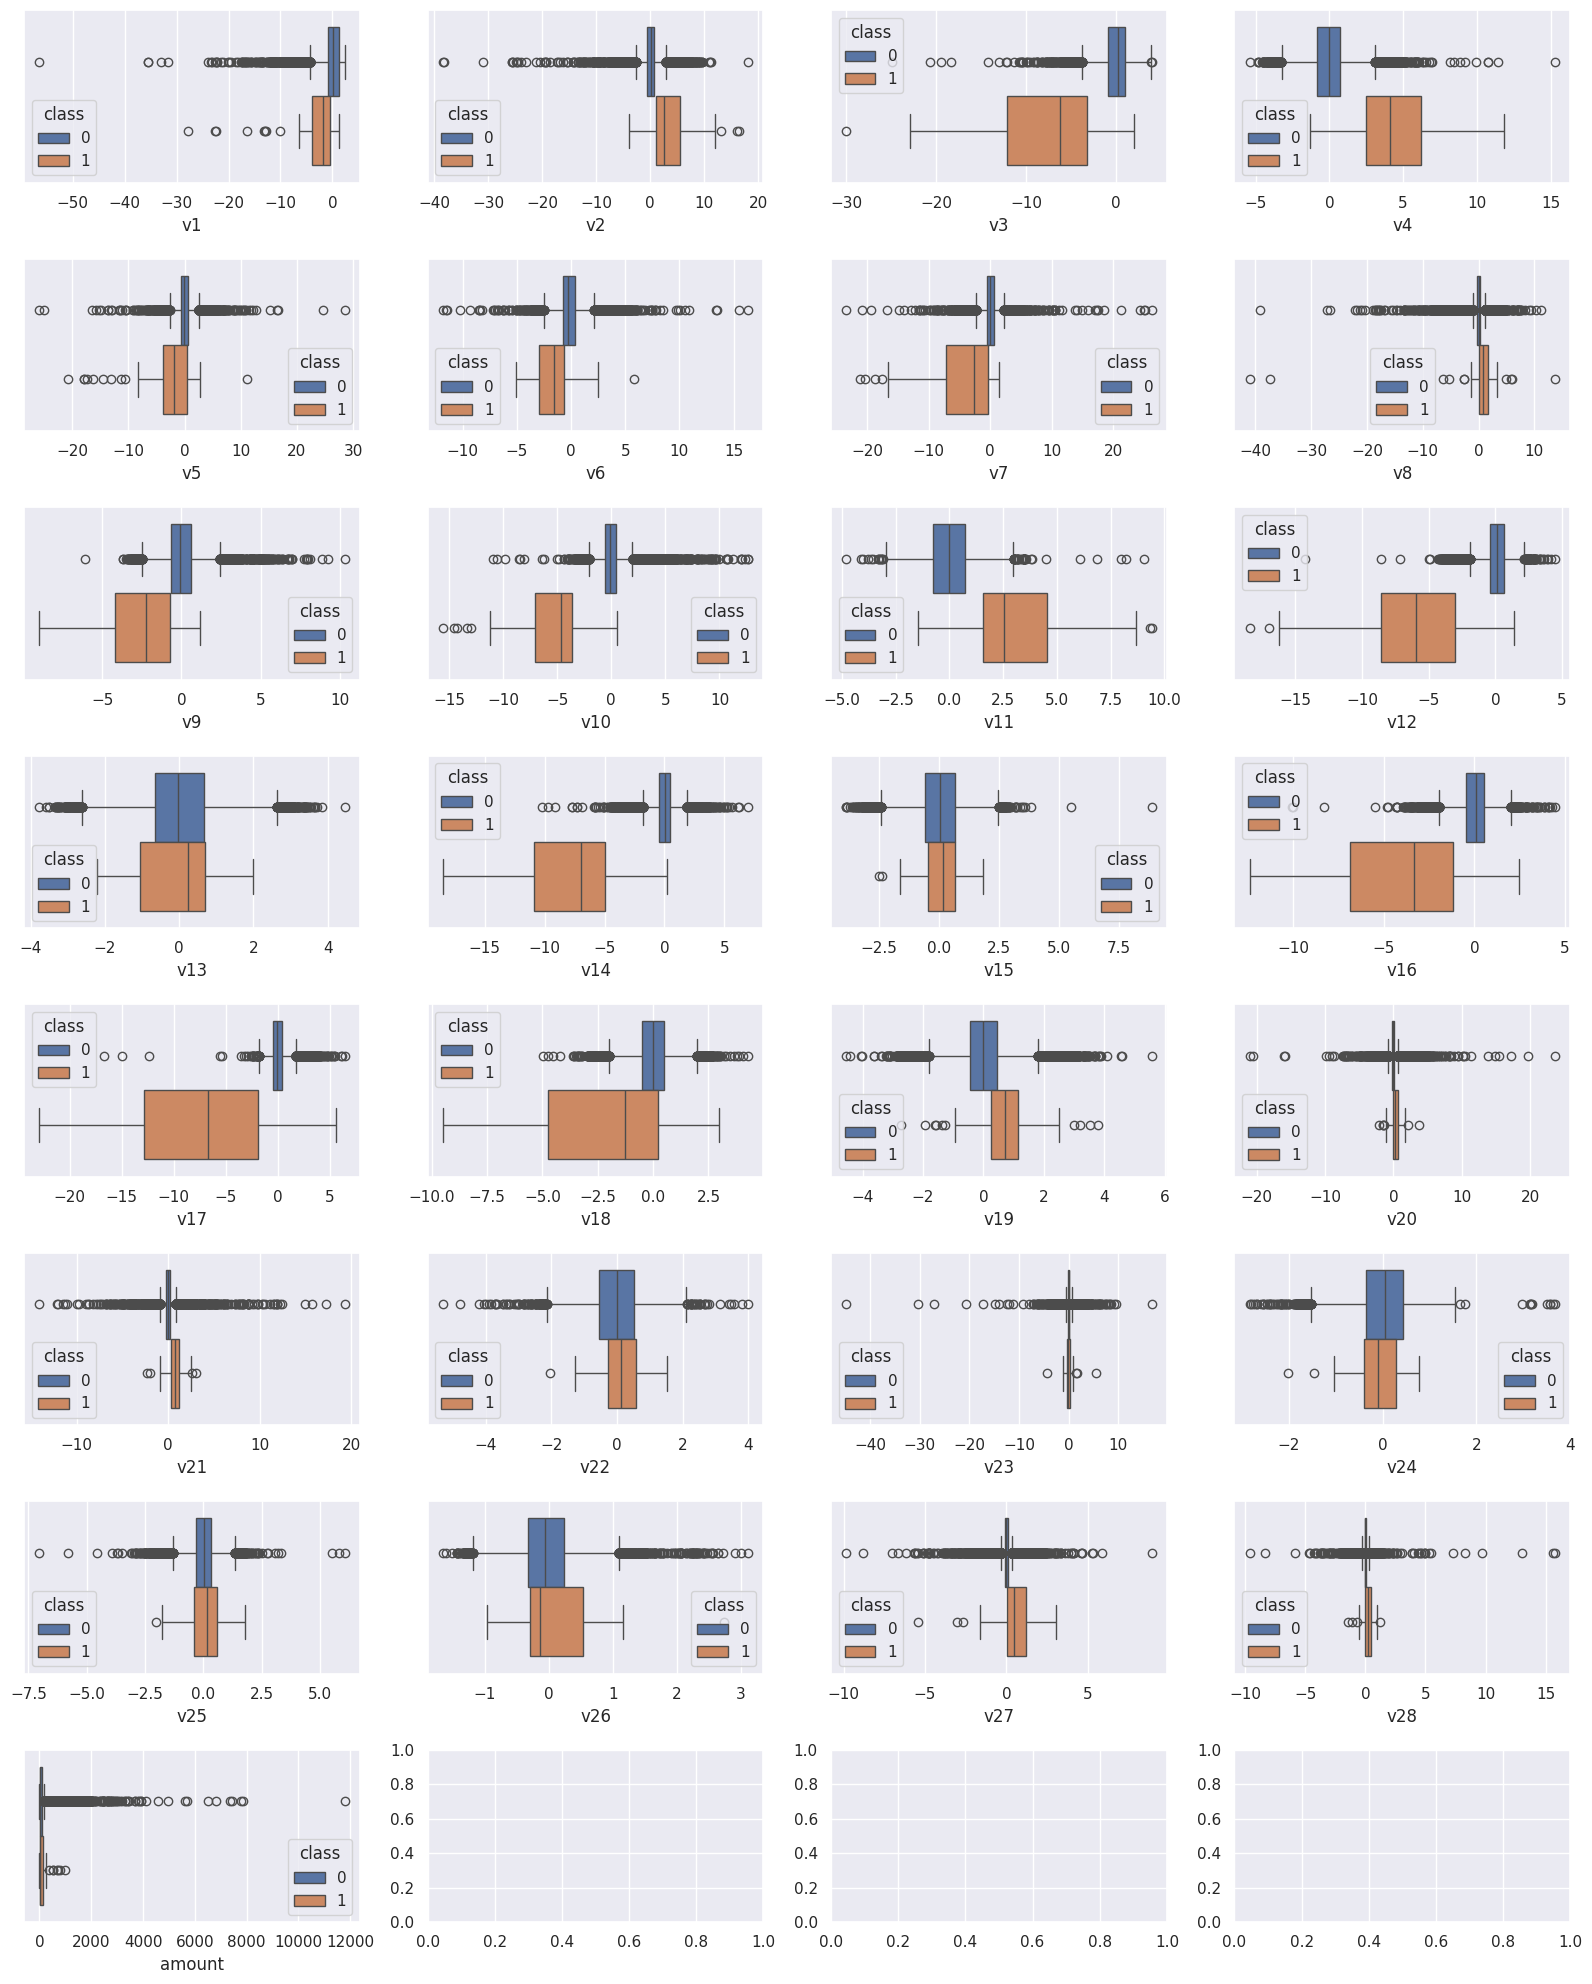

In [9]:
# comparing distributions with 10% of the data
sns.set(style="darkgrid")
fig, axes = plt.subplots(8, 4, figsize=(16, 20))
for i, col in enumerate(df.columns[1:-1]):
    sns.boxplot(data=df.sample(frac=0.1), x=col, hue='class', ax=axes[i // 4, i % 4])
plt.tight_layout()

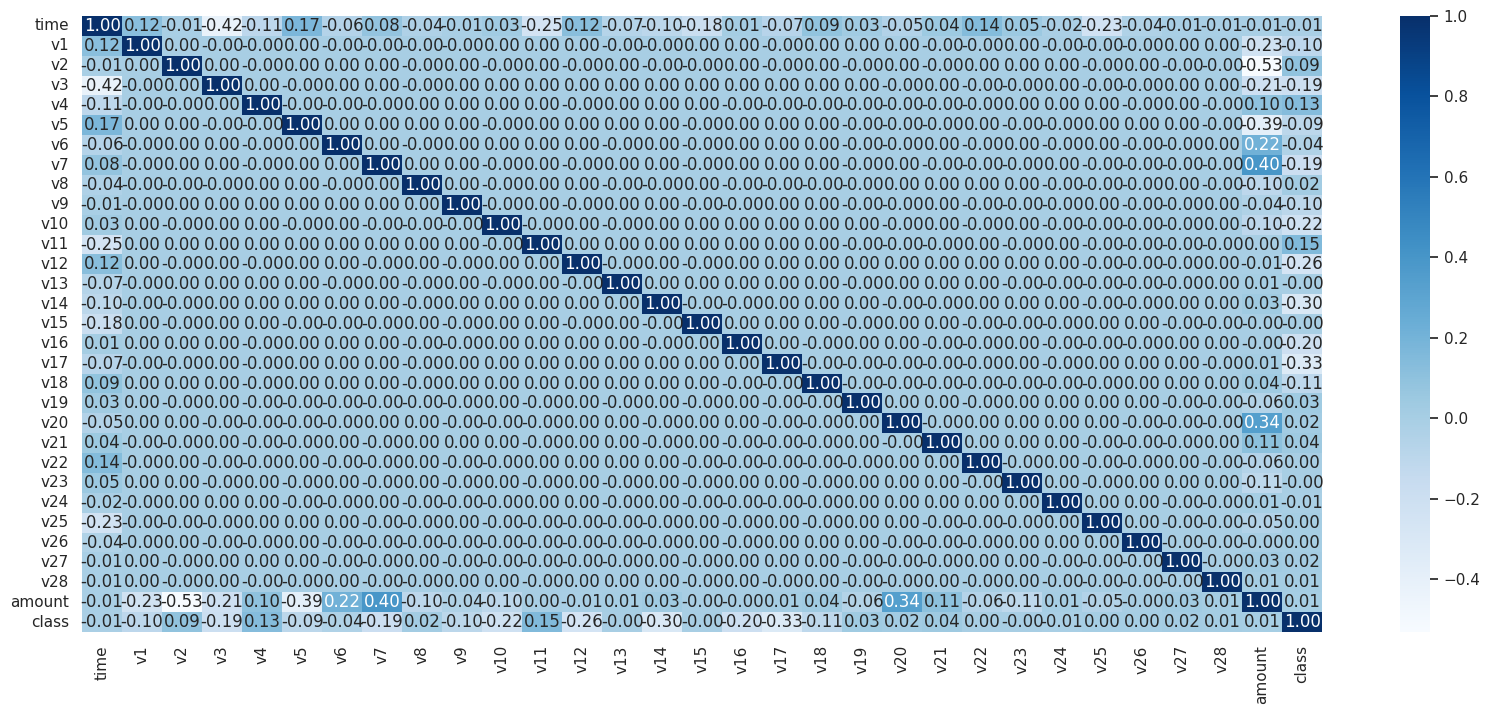

In [10]:
corr = df.corr()
plt.figure(figsize=(20, 8))
sns.heatmap(corr, cmap='Blues', annot=True, fmt='.2f');

No high colinearity between variables.

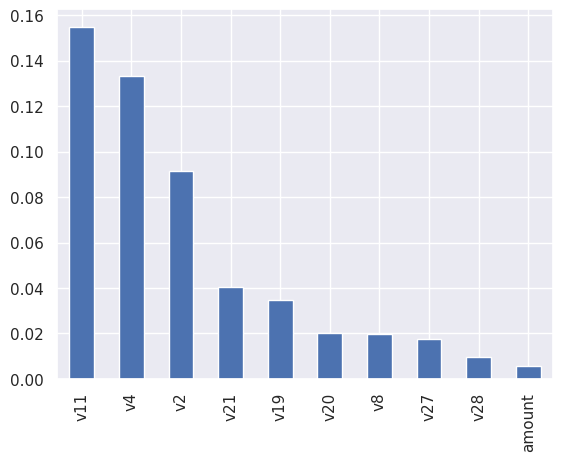

In [11]:
# feature importance based on correlation
corr['class'].sort_values(ascending=False)[1:11].plot(kind='bar');

# Data treatment

In [12]:
# Removing extreme outliers
Q1 = df['amount'].quantile(0.25)
Q3 = df['amount'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - (3 * IQR)
upper_bound = Q3 + (3 * IQR)

new_df = df[(df['amount'] >= lower_bound) & (df['amount'] <= upper_bound)]

In [13]:
# train test split
df_train = new_df.iloc[:200000]
df_test = new_df.iloc[200000:]

df_train.shape, df_test.shape

((200000, 31), (65866, 31))

# Treating the problem without considering concept drift

Under and over sampling was used to treat imbalanced data. Time column is not used as it has 0 correlation with class. Models tested:
- Logistic regression
- XGBoost
- Random Forest classifier

## Choosing a model

In [14]:
def sampling(yb):
  return {0: 20_000, 1: len(yb[yb == 1])}

# scalers and samplers
scaler = RobustScaler()
smote = SMOTE(sampling_strategy=692/199_654)
tomek = TomekLinks() # tomek links for undersampling
st = SMOTETomek(tomek=tomek, smote=smote, n_jobs=-1)
# fixed amount of instances
und = RandomUnderSampler(sampling_strategy=sampling, random_state=101)

models = [LogisticRegression(solver='liblinear'), XGBClassifier(), RandomForestClassifier()]

for model in models:
  steps = [
      ('scaler', scaler),
      ('combined', st),
      ('under', und),
      ('model', model)
  ]

  pipe = Pipeline(steps=steps)

  X = df_train.drop(['time', 'class'], axis=1)
  y = df_train['class']

  cv = cross_validate(pipe, X, y, cv=3, n_jobs=-1, scoring=['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted'])

  print(model)
  print('accuracy:', round(cv['test_accuracy'].mean(), 5))
  print('precision:', round(cv['test_precision_weighted'].mean(), 5))
  print('recall:', round(cv['test_recall_weighted'].mean(), 5))
  print('f1:', round(cv['test_f1_weighted'].mean(), 5))
  print ()

LogisticRegression(solver='liblinear')
accuracy: 0.99902
precision: 0.9992
recall: 0.99902
f1: 0.99907

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)
accuracy: 0.99919
precision: 0.99932
recall: 0.99919
f1: 0.99923

RandomForestClassifier()
accuracy: 0.99928
precision: 0.99939
recall: 0.

## Getting Predictions for Test Set

In [15]:
def sampling(yb):
  return {0: 20_000, 1: len(yb[yb == 1])}

# scalers and samplers
scaler = RobustScaler()
smote = SMOTE(sampling_strategy=692/199_654)
tomek = TomekLinks() # tomek links for undersampling
st = SMOTETomek(tomek=tomek, smote=smote, n_jobs=-1)
# fixed amount of instances
und = RandomUnderSampler(sampling_strategy=sampling, random_state=101)

X = df_train.drop(['time', 'class'], axis=1)
y = df_train['class']

X2 = scaler.fit_transform(X, y)
print ('2', X2.shape, len(y[y==0]), len(y[y==1]))

st_data = st.fit_resample(X2, y)
X3, y3 = st_data[0], st_data[1]
print ('3', len(X3), len(y3[y3==0]), len(y3[y3==1]))

X4, y4 = und.fit_resample(X3, y3)
print ('4', X4.shape, len(y4[y4==0]), len(y4[y4==1]))

# preparing test set for validation of the model
X_test = df_test.drop(['time', 'class'], axis=1)
y_test = df_test['class']
X_test = scaler.fit_transform(X_test, y_test)

rf = RandomForestClassifier()
rf.fit(X4, y4)
y_res = rf.predict(X_test)

2 (200000, 29) 199654 346
3 200339 199647 692
4 (20692, 29) 20000 692


In [16]:
# probability predictions
y_prob = rf.predict_proba(X_test)
model_data = pd.DataFrame({'time': df_test['time'], 'amount': df_test['amount'], 'true_label': y_test, 'pred_label': y_res, 
                           'prob_0': [i[0] for i in y_prob], 'prob_1': [i[1] for i in y_prob]}).reset_index(drop=True)

print(model_data.shape)
model_data.head()

(65866, 6)


,time,amount,true_label,pred_label,prob_0,prob_1
0,139737.0,172.51,0,0,1.00,0.00
1,139738.0,99.90,0,0,1.00,0.00
2,139738.0,27.99,0,0,1.00,0.00
3,139738.0,61.76,0,0,0.97,0.03
4,139739.0,168.00,0,0,1.00,0.00


## Prediction Metrics

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     65785
           1       0.86      0.74      0.79        81

    accuracy                           1.00     65866
   macro avg       0.93      0.87      0.90     65866
weighted avg       1.00      1.00      1.00     65866



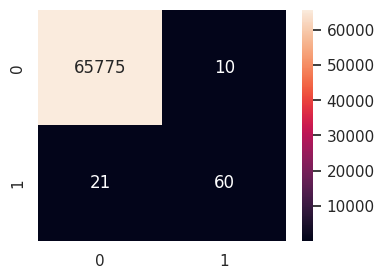

In [17]:
# checking performance
print(classification_report(y_test, y_res))

plt.figure(figsize=(4, 3))
sns.heatmap(confusion_matrix(y_test, y_res), annot=True, fmt='.0f');

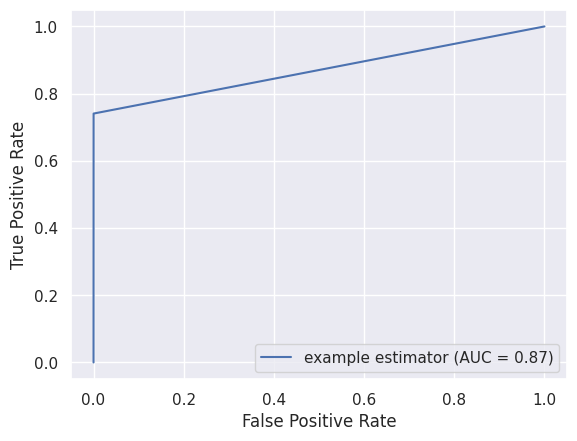

In [18]:
# ROC curve
fpr, tpr, thresholds = roc_curve(model_data['true_label'], model_data['pred_label'])
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                   estimator_name='example estimator')
display.plot();

In [19]:
# Kolmogorov-Smirnov
def ks(data):
    df_sorted = data.sort_values(by='prob_1', ascending=False)

    # cumulative percentages
    df_sorted['cum_pos'] = np.cumsum(df_sorted['true_label']) / np.sum(df_sorted['true_label'])
    df_sorted['cum_neg'] = np.cumsum(1 - df_sorted['true_label']) / np.sum(1 - df_sorted['true_label'])

    # maximum KS
    df_sorted['ks'] = np.abs(df_sorted['cum_pos'] - df_sorted['cum_neg'])
    max_ks = df_sorted['ks'].max()

    return max_ks

rf_ks = ks(model_data)
rf_ks

0.8589884556594293

KS higher than 80% indicates an excellent separation between good and bad predictions (discrimination).



## Savings with fraud detection

In [20]:
fraud_cost_test = (model_data[model_data['true_label'] == 1]['amount'].sum() * 2.07)
predicted_frauds = model_data[(model_data['true_label'] == 1) & (model_data['pred_label'] == 1)].shape[0]
total_frauds = model_data[(model_data['true_label'] == 1)].shape[0]
prevented_loss = model_data[(model_data['true_label'] == 1) & (model_data['pred_label'] == 1)]['amount'].sum() * 2.07
test_set_duration = dt.timedelta(seconds=(model_data['time'].max() - model_data['time'].min()))
prevented_cost_year = 10 * (9.2/24) * prevented_loss * 365
fraud_cost_test_year = 10 * (9.2/24) * 365 * (model_data[model_data['true_label'] == 1]['amount'].sum() * 2.07)

print(f"Total cost of fraud on test set: {fraud_cost_test:,.2f} Euros")
print(f"Predicted frauds: {predicted_frauds} out of {total_frauds} transactions")
print(f"Prevented {prevented_loss:,.2f} Euros in fraud losses in {test_set_duration} hours")
print(f"Prevents {prevented_cost_year:,.2f} Euros in one year with fraud detection out of {fraud_cost_test_year:,.2f} total fraud cost \
({(100 * prevented_cost_year / fraud_cost_test_year):,.2f}%)")

Total cost of fraud on test set: 5,351.67 Euros
Predicted frauds: 60 out of 81 transactions
Prevented 4,608.25 Euros in fraud losses in 9:10:55 hours
Prevents 6,447,716.37 Euros in one year with fraud detection out of 7,487,884.57 total fraud cost (86.11%)


## Detecting Drift in Prediction

# Considering Concept Drift

Steps to deal with concept drift in the data:
- build adaptive model (Hoeffding tree and ARF)
- analyze with specific metrics (KS, PSI, PH)